# Défi EGC 2024

### import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scripts.data_frame_generator import generate_external_time_series,generate_global_time_series, generate_blockchain_by_actor, min_max_norm,std_scale

### Récupérer les séries temporelles extérieures

In [2]:
external_df = generate_external_time_series("timeseries/external.csv")

### Affichage du HashRate et du prix en dollars

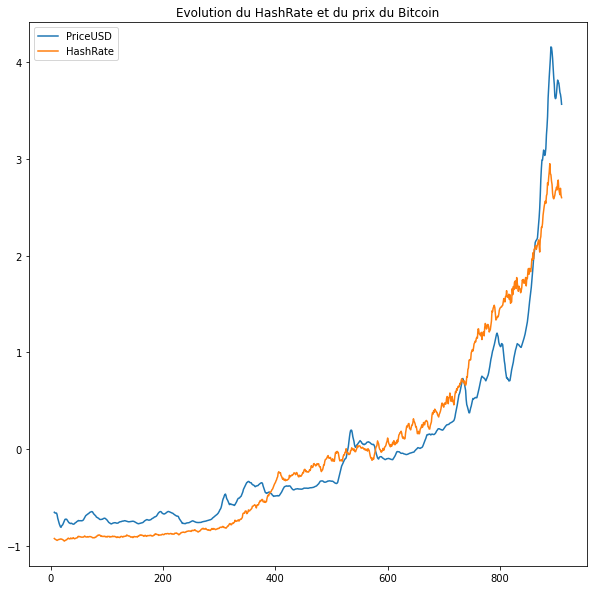

In [165]:
fig, ax1 = plt.subplots( figsize=(10, 10))
# Normalisation des données
std_scaler = StandardScaler()
df_normalized = std_scaler.fit_transform(external_df)
df_normalized = pd.DataFrame(np.array(df_normalized, dtype=np.float64), columns=external_df.columns)
# Lissage et affichage de la courbe
df_normalized.rolling(window=7).mean().plot(ax=ax1)
plt.title("Evolution du HashRate et du prix du Bitcoin")
plt.legend()
plt.show()

#### Evaluation des correlation entre HashRate et le prix du Bitcoin en Dollar

In [4]:
correlation_matrix = external_df.corr()
correlation_matrix

,PriceUSD,HashRate
PriceUSD,1.000000,0.937447
HashRate,0.937447,1.000000


On peut remarquer ici que le score de correlation de Pearson entre le PriceUSD et le HashRate est de 0.93, ce qui signifie que les PriceUSD et Hashrate on une relation linéaire qui est proche.

### Travail sur les 100 principaux acteurs de la blockcahin

In [225]:
block_chain_df = generate_blockchain_by_actor('timeseries/blockchain_by_actor.csv')
column_to_analyze = 'received'
block_chain_df.groupby('identity')[[column_to_analyze]].sum().sort_values(by=column_to_analyze, ascending=False).head()

,received
identity,
Huobi.com,1.313671e+15
ePay.info_CoinJoinMess,1.188925e+15
Bitstamp.net,6.997821e+14
BTC-e.com,5.370579e+14
OKCoin.com,4.589288e+14


In [226]:
short_blochain_df = block_chain_df.copy()


On veut chercher ici à trouver des correlation sur l'évolution de chaque acteurs entre eux à savoir si deux acteurs ont une activité qui évolue de manière similaire comme il a été fait pour l'analyse du HashRate et du cours du Bitcoin.

In [227]:
df_unstacked = short_blochain_df.groupby(['date', 'identity'])[column_to_analyze].mean().unstack()
actor_correlation_matrix = df_unstacked.corr()
np.fill_diagonal(actor_correlation_matrix.values,0)
actor_correlation_matrix

identity,0,101,107,1070,1138,1149,122,1226,1391,154,...,SatoshiDice.com,SatoshiMines.com,SecondsTrade.com,SimpleCoin.cz,SlushPool.com,TheRockTrading.com,Vaultoro.com,Xapo.com,YoBit.net,ePay.info_CoinJoinMess
identity,,,,,,,,,,,,,,,,,,,,,
0,0.000000,-0.002868,0.024539,0.009381,-0.058205,0.005831,0.257217,-0.002767,-0.082583,0.038719,...,-0.043644,-0.065298,0.024595,0.238960,-0.033586,0.146989,0.117818,0.054840,0.088779,-0.003019
101,-0.002868,0.000000,-0.245643,-0.112050,-0.225835,0.038723,0.302529,-0.035567,-0.094657,0.320706,...,-0.178255,-0.244509,-0.178233,0.190444,-0.151607,0.004009,0.012944,0.030834,0.570701,-0.442839
107,0.024539,-0.245643,0.000000,0.104498,0.380961,-0.045815,-0.237961,0.013299,-0.078091,-0.264149,...,0.202477,0.159081,0.128739,-0.047499,0.412069,-0.121735,-0.029456,0.056248,-0.308410,0.316534
1070,0.009381,-0.112050,0.104498,0.000000,0.143482,-0.026292,0.022001,0.028638,0.071289,-0.046768,...,0.119448,-0.017968,0.093629,0.082672,0.111274,0.054484,-0.016339,0.017156,-0.100266,0.160219
1138,-0.058205,-0.225835,0.380961,0.143482,0.000000,-0.044187,-0.252883,0.038303,0.032900,-0.270654,...,0.202375,0.193766,0.121472,-0.128052,0.244948,-0.143584,-0.073228,-0.012340,-0.272512,0.267618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TheRockTrading.com,0.146989,0.004009,-0.121735,0.054484,-0.143584,-0.020754,0.267426,0.006484,0.071854,0.150548,...,-0.072225,-0.109796,0.014360,0.192423,-0.136308,0.000000,0.155773,-0.001909,0.108604,0.041437
Vaultoro.com,0.117818,0.012944,-0.029456,-0.016339,-0.073228,-0.023879,0.265219,-0.040322,-0.044391,0.058241,...,-0.062612,-0.083395,-0.034137,0.163631,0.028462,0.155773,0.000000,0.051019,0.084550,-0.079479
Xapo.com,0.054840,0.030834,0.056248,0.017156,-0.012340,-0.009953,0.097988,0.025627,-0.041954,0.050945,...,-0.050495,-0.055240,-0.061821,0.117370,-0.032664,-0.001909,0.051019,0.000000,0.026042,-0.075766


In [228]:
s = actor_correlation_matrix.stack()
max_index = s.idxmax()[0]
max_col = actor_correlation_matrix.loc[max_index].idxmax()
max_value = actor_correlation_matrix[max_col].loc[max_index]
max_index, max_col

('BTCC.com', 'BtcTrade.com')

In [229]:
print(f"La valeur maximale est {max_value} et elle se trouve à l'index  '{max_index}' dans la colonne '{max_col}'")

La valeur maximale est 0.9021413876901954 et elle se trouve à l'index  'BTCC.com' dans la colonne 'BtcTrade.com'


<Axes: xlabel='date'>

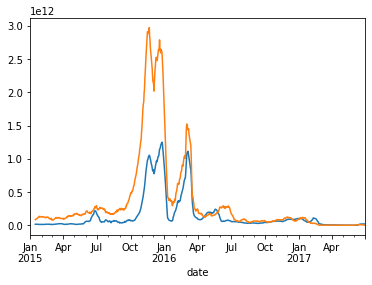

In [234]:
window = 15
max_col_df = block_chain_df[block_chain_df['identity'] == max_col][column_to_analyze]
max_col_df.rolling(window=window).mean().plot()


max_index_df = block_chain_df[block_chain_df['identity'] == max_index][column_to_analyze]
max_index_df.rolling(window=window).mean().plot()


On remarque une augmentation du nombre de transactions vers avril 2016 ainsi qu'une baisse vers juillet dans les deux courbes. On notera que le nombre de transaction n'est pas du même ordre de grandeur.

On peut alors se poser la question si l'activité de certains groupes d'acteurs sont corrélées entre elles.

In [231]:
max_values = actor_correlation_matrix.apply(lambda x: pd.Series({'max_index': x.idxmax(), 'max_value': x.max()}), axis=1)
tresh_old = 0.8
max_values[max_values['max_value'] >= tresh_old].sort_values('max_value')

,max_index,max_value
identity,,
BTCC.com,BtcTrade.com,0.902141
BtcTrade.com,BTCC.com,0.902141


In [232]:
max_row = max_values.loc[max_values['max_value'].idxmax()]
max_index =  max_values['max_value'].idxmax()

Text(0.5, 1.0, "Comparison of 'received' between BtcTrade.com and BTCC.com")

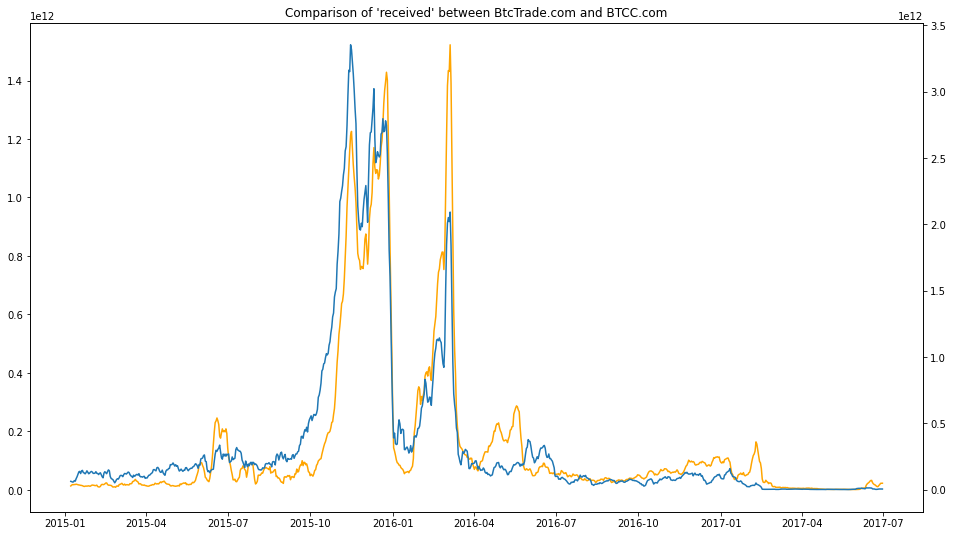

In [247]:
key1,key2 = max_row['max_index'], max_index
f1, ax1 = plt.subplots(figsize=(16,9))
ax2 = ax1.twinx()
temp_df = block_chain_df[block_chain_df['identity'] == key1][column_to_analyze]

ax1.plot(temp_df.rolling(window=7).mean(),color='orange')
temp_df = block_chain_df[block_chain_df['identity'] == key2][column_to_analyze]
ax2.plot(temp_df.rolling(window=7).mean())
plt.title(f"Comparison of '{column_to_analyze}' between {max_col} and {max_index}")